In [38]:
# JBY: Set up env using "ipython --pylab" imports
%pylab
%autoreload 2

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/jason/virtualenvs/default/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['interactive']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [39]:
interactive = False
if interactive:
    %matplotlib osx
else:
    %matplotlib inline
figsize(17,6)
rcParams['font.size'] = 18

In [40]:
import pandas as pd
import json
import os

In [41]:
# Local imports
from helper import colors, primary_tags, primary_tag_set, primary_tags_carbonplan_pt_order, get_pt, get_clr, lsprint, display_full

# Misc function definitions

In [42]:
global_skip_save = False

def savefigs(name):
    if not global_skip_save:
        savefig('%s.png' % name)
        savefig('%s.pdf' % name)

# Load data

In [43]:
first_year = 2020
last_year = 2035
n_years = last_year - first_year + 1       # 16 years from 2020 - 2035, inclusive

In [44]:
with open(os.path.join(os.getcwd(), '..', 'data', 'Supply_Cost_Projections_df.csv'), 'r') as ff:
    df = pd.read_csv(ff)

In [45]:
#df = pd.json_normalize(whole_json['projects'])

In [46]:
df.shape

(206, 116)

In [47]:
#df.head()

# Clean and standardize data

In [48]:
# Convert from string like "['forests', 'reforestation']" to list of strings
if df.tags.isna().any():
    raise Exception('Missing tags for these entries. Populate them in the spreadsheet and re-download:\n%s' % df.id[df.tags.isna()])
df.tags = df.tags.map(lambda x: json.loads(x.replace("'", '"')))

In [49]:
# If people left "applicant" blank, fill it in with data from the ID column
sel = df.applicant.isna()
df.loc[sel, 'applicant'] = df.loc[sel, 'id']

## Cost and volume data

If cost is provided in cost_2020_min column, take it as valid.

If not, then if cost is provided in cost_value column AND the cost_rating is not -9999, copy to cost_2020_min colum and mark as valid.

Note that this rules out two MS Forestry projects that have a cost but where it is marked as -9999 (unless someone researches those options and enters their evaluation of the cost in cost_2020_min)

In [50]:
selector_copy_from_cost_val = (df.cost_value.map(bool) & 
                               (df.cost_rating != -9999) & 
                               (df.cost_2020_min.isna()))
df.loc[selector_copy_from_cost_val, 'cost_2020_min'] = df[selector_copy_from_cost_val].cost_value
df['valid_cost'] = df.cost_2020_min.notna()

Ditto for volume

In [51]:
selector_copy_from_volume_val = (df.volume_value.map(bool) & 
                                (df.volume_rating != -9999) & 
                                (df.vol_2020_min.isna()))
df.loc[selector_copy_from_volume_val, 'vol_2020_min'] = df[selector_copy_from_volume_val].volume_value
df['valid_volume'] = df.vol_2020_min.notna()

Mark those rows with valid volume and cost. Only these rows will be plotted later

In [52]:
df['valid_vc'] = (df['valid_volume'] & df['valid_cost'])

In [53]:
# Ensure permanence_value is filled in where needed
# If you overlook this Exception many plots can still be made, but adjustments for leakage later will fail.
sel = (df.valid_vc & df.permanence_value.isna())
if sel.any():
    raise Exception('Missing permanance_value for these entries. Populate them in the spreadsheet and re-download:\n%s' % df.id[sel])

In [54]:
# Function defs

def get_array_all_years(project, pattern):
    '''Pattern like "cost_%s_min"'''
    return array([getattr(project, pattern % year) for year in range(first_year, last_year + 1)])

def min_cost_array(project): return get_array_all_years(project, 'cost_%s_min')
def max_cost_array(project): return get_array_all_years(project, 'cost_%s_max')
def min_vol_array(project): return get_array_all_years(project, 'vol_%s_min')
def max_vol_array(project): return get_array_all_years(project, 'vol_%s_max')

def min_cost_df(project): return pd.DataFrame(get_array_all_years(project, 'cost_%s_min'))
def max_cost_df(project): return pd.DataFrame(get_array_all_years(project, 'cost_%s_max'))
def min_vol_df(project): return pd.DataFrame(get_array_all_years(project, 'vol_%s_min'))
def max_vol_df(project): return pd.DataFrame(get_array_all_years(project, 'vol_%s_max'))

def get_costs(project):
    '''Return average costs for all years'''
    #c_min = array([getattr(project, 'cost_%s_min' % year) for year in range(first_year, last_year + 1)])
    #c_max = array([getattr(project, 'cost_%s_max' % year) for year in range(first_year, last_year + 1)])    
    return (min_cost_array(project) + max_cost_array(project)) / 2

def get_vols(project):
    '''Return average volumes for all years'''
    #v_min = array([getattr(project, 'vol_%s_min' % year) for year in range(first_year, last_year + 1)])
    #v_max = array([getattr(project, 'vol_%s_max' % year) for year in range(first_year, last_year + 1)])    
    return (min_vol_array(project) + max_vol_array(project)) / 2

def write_yearly_data_to_df(df, idx, yearly_data_array, pattern):
    '''Writes the data in yearly_data_array back to df at the given row index and
    for all years to the columns described by pattern.
    Ugly, but 🤷‍♂️'''
    
    assert len(yearly_data_array) == n_years, 'Wrong length data'
    for ii, year in enumerate(range(first_year, last_year + 1)):
        df.at[idx, pattern % year] = yearly_data_array[ii]

Interpolate any missing data exponentially in time. Uses [pandas.DataFrame.interpolate](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html)

In [55]:
# Make non-null volumes at least 10 to avoid very low values on log-scale volume plots
# and problems with exponential interpolation

for year in range(first_year, last_year + 1):
    col = 'vol_%s_min' % year
    sel = df.valid_vc & df[col].notna() & (df[col] < 10.0)
    df.loc[sel, col] = 10.0
    
    col = 'vol_%s_max' % year
    sel = df.valid_vc & df[col].notna() & (df[col] < 10.0)
    df.loc[sel, col] = 10.0

In [56]:
def exponential_interpolate(df):
    for project in df.itertuples():
        if not project.valid_vc:
            continue
        #print(project.Index)
        
        tmp = exp(log(min_cost_df(project)).interpolate()).to_numpy()
        write_yearly_data_to_df(df, project.Index, tmp, 'cost_%s_min')

        tmp = exp(log(max_cost_df(project)).interpolate()).to_numpy()
        write_yearly_data_to_df(df, project.Index, tmp, 'cost_%s_max')

        tmp = exp(log(min_vol_df(project)).interpolate()).to_numpy()
        write_yearly_data_to_df(df, project.Index, tmp, 'vol_%s_min')

        tmp = exp(log(max_vol_df(project)).interpolate()).to_numpy()
        write_yearly_data_to_df(df, project.Index, tmp, 'vol_%s_max')
                
        #write_min_costs(min_costs)

In [57]:
exponential_interpolate(df)

Make non-null volumes at least 10 to avoid zero or very low values on log-scale volume plots. Make max always at least as large as min.

In [58]:
# Make max always at least as large as min and fill max in with min if it's blank

for year in range(first_year, last_year + 1):    
    # Copy any min cost to max if max is less or nan
    min_col, col = ('cost_%s_min' % year), ('cost_%s_max' % year)
    sel = df.valid_vc & (~(df[col] > df[min_col]))
    df.loc[sel, col] = df.loc[sel, min_col]

    # Copy any min vol to max if max is less or nan
    min_col, col = ('vol_%s_min' % year), ('vol_%s_max' % year)
    sel = df.valid_vc & (~(df[col] > df[min_col]))
    df.loc[sel, col] = df.loc[sel, min_col]

Run some basic checks

In [59]:
def assert_mins_maxes_are_sane():
    for year in range(first_year, last_year + 1):
        assert df[df.valid_vc]['cost_%s_min' % year].notnull().all(), year
        assert df[df.valid_vc]['cost_%s_max' % year].notnull().all(), year
        assert df[df.valid_vc]['vol_%s_min' % year].notnull().all(), year
        assert df[df.valid_vc]['vol_%s_max' % year].notnull().all(), year
        assert (df[df.valid_vc]['cost_%s_max' % year] >= df[df.valid_vc]['cost_%s_min' % year]).all(), year
        assert (df[df.valid_vc]['vol_%s_max' % year] >= df[df.valid_vc]['vol_%s_min' % year]).all(), year

In [60]:
# Run some basic checks
assert_mins_maxes_are_sane()

## Misc checks, cleaning, and standardization

In [61]:
# Check volume_units
unique_units = df[df.valid_vc].volume_units.dropna().unique()
assert len(unique_units) == 1, 'Expected only one unit'
assert unique_units[0] == 'tCO₂', 'Expected other unit'

# Check permanence_units
unique_units = df[df.valid_vc].permanence_units.dropna().unique()
assert len(unique_units) == 1, 'Expected only one unit'
assert unique_units[0] == 'years', 'Expected other unit'

# Check cost_units
assert (df[df.cost_units == '$/tCO₂-year'].permanence_value == 1).all(), 'Need to deal with different units. Cost is given as %/t/y but permanence is not 1.0 years'
unique_units = set(df[df.valid_vc].cost_units.dropna().unique())
unique_units.discard('$/tCO₂-year')
assert len(unique_units) == 1, 'Expected only one cost unit (possibly besides $/tCO₂-year)'
assert list(unique_units)[0] == '$/tCO₂', 'Expected other unit'

If pt is missing, fill in from tags column

In [62]:
sel = df.pt.isna()
df.loc[sel, 'pt'] = df.tags.map(get_pt)

# Check that pt column is filled in correctly
assert (df.pt != df.tags.map(get_pt)).sum() == 0, 'Some primary tag stored in the pt column does not match the computed primary tag.'

# Does any project not have a primary tag?
print(((df.pt == 'none') | (df.pt.isna())).sum(), 'projects are missing a primary tag')

0 projects are missing a primary tag


Extract different aggregation groups

In [63]:
projection_groups = {}
print('Available projection groups by primary tag:')
for pt in primary_tags:
    projection_groups[pt] = list(df[df.pt == pt].projection_group.unique())
    print('%16s: %s' % (pt, projection_groups[pt]))

Available projection groups by primary tag:
         forests: ['company', 'aggregate']
            soil: ['company', 'disabled', 'aggregate']
         biomass: ['company', 'disabled', 'aggregate']
           ocean: ['company', 'disabled', 'aggregate']
  mineralization: ['company', 'disabled', 'aggregate']
             dac: ['disabled', 'company', 'aggregate']


In [64]:
# Get selector the prefers "aggregate" grouping but falls back to "company" if not available
print('Selections for "aggregate" grouping with fallback to companies:')
sel_prefer_aggregate = False & df.valid_vc    # Initially select nothing
for pt, groups in projection_groups.items():
    which_group = 'aggregate' if 'aggregate' in groups else 'company'
    sel_this = (df.pt == pt) & (df.projection_group == which_group)
    print('%16s: selected %3d entries from group %s' % (pt, sel_this.sum(), which_group))
    sel_prefer_aggregate |= sel_this

Selections for "aggregate" grouping with fallback to companies:
         forests: selected   2 entries from group aggregate
            soil: selected   1 entries from group aggregate
         biomass: selected   2 entries from group aggregate
           ocean: selected   1 entries from group aggregate
  mineralization: selected   2 entries from group aggregate
             dac: selected   1 entries from group aggregate


In [65]:
# Note from Jason: this is not used yet but could be useful to define before final presentation
# Get a selector uses only the "summary" grouping with no fallback
sel_just_summary = (df.valid_vc & (df.projection_group == 'summary'))

In [66]:
assert set(primary_tags_carbonplan_pt_order) == primary_tag_set, 'Set of primary tags must be the same!'
print('Primary tags in plot order:\n', primary_tags)
print('Primary tags in pt order:  \n', primary_tags_carbonplan_pt_order)

Primary tags in plot order:
 ['forests', 'soil', 'biomass', 'ocean', 'mineralization', 'dac']
Primary tags in pt order:  
 ['forests', 'soil', 'biomass', 'dac', 'mineralization', 'ocean']


In [67]:
# Add clr column
df['clr'] = df.tags.map(get_clr)

Flatten tags for easier filtering and show how many projects have each tag

In [68]:
tagset = set()
for tags in df.tags:
    for tag in tags:
        tagset.add(tag)
taglist = sorted(list(tagset))

# Create boolean field for each tag, e.g. t_dac and t_ocean
for tag in taglist:
    df['t_%s' % tag] = df.tags.map(lambda x: tag in x)
# n_tags
df['n_tags'] = df.tags.map(len)

for tag in taglist:
    print('%4d: %s' % (df['t_%s' % tag].sum(), tag))

   1: aggregate
   1: agroforestry
  15: biochar
  37: biomass
   5: concrete
   6: conversion
   5: dac
  15: farming
 113: forests
  10: grazing
  40: ifm
  14: injection
   2: insulation
   5: macroalgae
  16: mineralization
  10: ocean
   4: olivine
   2: phytoplankton
   4: redd+
  63: reforestation
  31: soil
   3: storage
   1: wetlands
   7: wood


# Data basics

In [69]:
df.head(5)

,id,tags,description,applicant,rating,keywords,methods,revisions,location.name,source.name,...,t_ocean,t_olivine,t_phytoplankton,t_redd+,t_reforestation,t_soil,t_storage,t_wetlands,t_wood,n_tags
0,STRP007,"[forests, reforestation]",Reforestation using heavy-lift drones and seed...,Droneseed,2.0,NaN,Project reports a volume of 510 tCO₂ in the fi...,"[{'date': '05-18-2020', 'note': 'First release...","WA, USA",Stripe 2020 Negative Emissions Purchase,...,False,False,False,False,True,False,False,False,False,2
1,STRP008,"[forests, reforestation]",Reforestation with verification and monitoring...,Pachama,1.0,"Rip's Redwoods, Guanare",Project directly reports rates of 16 tCO₂ / ha...,"[{'date': '05-18-2020', 'note': 'First release...","Uruguay & CA, USA",Stripe 2020 Negative Emissions Purchase,...,False,False,False,False,True,False,False,False,False,2
2,STRP012,"[forests, ifm]",Forest carbon rental markets.,SilviaTerra,3.0,NaN,This project is based on a novel forest carbon...,"[{'date': '05-18-2020', 'note': 'First release...",Southern USA,Stripe 2020 Negative Emissions Purchase,...,False,False,False,False,False,False,False,False,False,2
3,STRP013,"[forests, agroforestry]",Conversion of annual cropland to sheep/chestnu...,Breadtree Farms,1.0,NaN,Project claims a range of 56 tCO₂ to 140 tCO₂ ...,"[{'date': '05-18-2020', 'note': 'First release...","Johnsonville, NY, USA",Stripe 2020 Negative Emissions Purchase,...,False,False,False,False,False,False,False,False,False,2
4,STRP019,"[forests, reforestation]",Reforestation offset model.,Future Forest,1.0,NaN,"For a 174 ha land project in Scotland, project...","[{'date': '05-18-2020', 'note': 'First release...",Scotland,Stripe 2020 Negative Emissions Purchase,...,False,False,False,False,True,False,False,False,False,2


In [70]:
print('Columns in df:')
lsprint(df.columns.to_list())

Columns in df:
 id                  permanence_value       cost_2026_min  vol_2023_min  valid_cost       
 tags                permanence_units       cost_2027_min  vol_2024_min  valid_volume     
 description         permanence_rating      cost_2028_min  vol_2025_min  valid_vc         
 applicant           permanence_notes       cost_2029_min  vol_2026_min  clr              
 rating              permanence_comment     cost_2030_min  vol_2027_min  t_aggregate      
 keywords            additionality_value    cost_2031_min  vol_2028_min  t_agroforestry   
 methods             additionality_units    cost_2032_min  vol_2029_min  t_biochar        
 revisions           additionality_rating   cost_2033_min  vol_2030_min  t_biomass        
 location.name       additionality_notes    cost_2034_min  vol_2031_min  t_concrete       
 source.name         additionality_comment  cost_2035_min  vol_2032_min  t_conversion     
 source.license      cost_value             cost_2020_max  vol_2033_min  t_

# Define cost adjustments for credit leakage

In [71]:
def get_leak_cost_mult(permanence, wacc=1.05, model='exponential'):
    if model == 'exponential':
        return 1 + (1 - exp(-1/permanence)) * 1/(1 - 1/wacc) / wacc
    else:
        raise Exception('Unrecognized model: %s' % model)

# Plots

## Reproduce Carbon Plan plots

Note: the first versions of these plots matched those on the [Carbon Plan CDR Database](https://carbonplan.org/research/cdr-database) exactly (except Carbon Plan seems to clip their volumes as plotted to the [10, 1M] window). Subsequent edits to the data have moved some points

In [72]:
# For these plots, filter just to the 'company' projection group
sel = (df.projection_group == 'company')

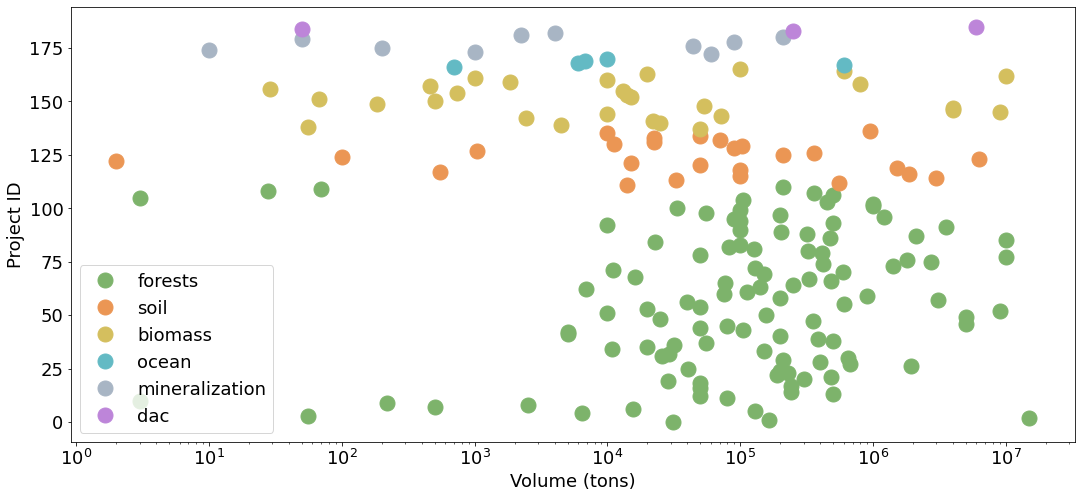

In [73]:
figsize(18,8)
clr_handles = {tag: None for tag in primary_tags}
for ii, project in enumerate(df[sel].itertuples()):
    clr = project.clr
    volume = project.volume_value
    hh, = semilogx(volume, ii, 'o', mec=clr, mfc=clr, ms=15)
    clr_handles[project.pt] = hh
xlabel('Volume (tons)')
ylabel('Project ID')
legend(clr_handles.values(), clr_handles.keys())
savefigs('carbon_plan_type_vol_separate')

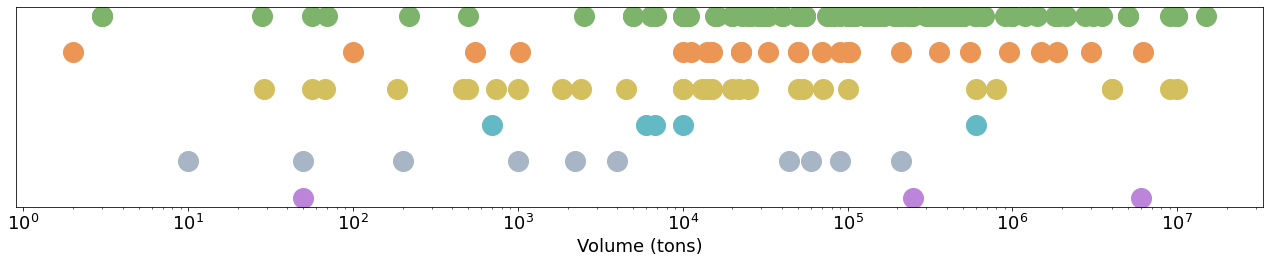

In [74]:
figsize(18,4)
for ii, project in enumerate(df[sel].itertuples()):
    clr = project.clr
    y_coord = (-len(primary_tags)) if project.pt == 'none' else -primary_tags.index(project.pt)
    volume = project.volume_value
    semilogx(volume, y_coord, 'o', mec=clr, mfc=clr, ms=20)
xlabel('Volume (tons)')
yticks([])
tight_layout()
savefigs('carbon_plan_type_vol')

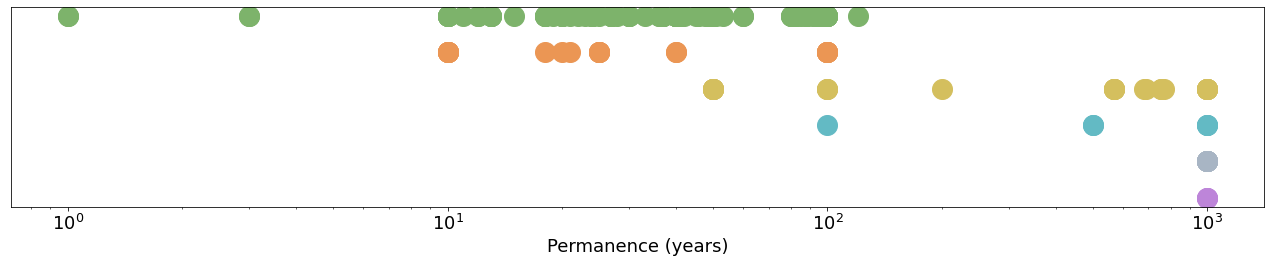

In [75]:
figsize(18,4)
for ii, project in enumerate(df[sel].itertuples()):
    clr = project.clr
    y_coord = (-len(primary_tags)) if project.pt == 'none' else -primary_tags.index(project.pt)
    permanence = project.permanence_value
    semilogx(permanence, y_coord, 'o', mec=clr, mfc=clr, ms=20)
xlabel('Permanence (years)')
yticks([])
tight_layout()
savefigs('carbon_plan_type_permanence')

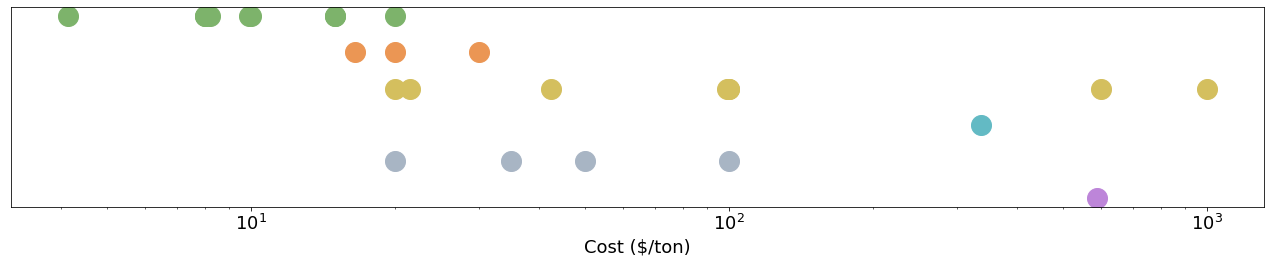

In [76]:
figsize(18,4)
for ii, project in enumerate(df[sel].itertuples()):
    clr = project.clr
    y_coord = (-len(primary_tags)) if project.pt == 'none' else -primary_tags.index(project.pt)
    cost = project.cost_value
    semilogx(cost, y_coord, 'o', mec=clr, mfc=clr, ms=20)
xlabel('Cost ($/ton)')
yticks([])
tight_layout()
savefigs('carbon_plan_type_cost')

## Volume vs. Cost as Points (`vcp_*` files)

In [77]:
def nice_vc_axes(skip_x=False):
    ax = axis()
    yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
            10, 20, 30, 40, 50, 60, 70, 80, 90,
            100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
           2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])
    grid(b=True, which='major', c=(.85, .85, .85), ls='--')
    gca().yaxis.set_major_formatter('${x:1.0f}')
    if not skip_x:
        xticks(10 ** arange(3*4),
               ['1', '10', '100', '1k', '10k', '100k', '1M', '10M', '100M', '1G', '10G', '100G'])
    axis(ax)  # Necessary to avoid plot expanding to include all ticks

In [104]:
def plot_vcp(df, start=2020, end=2025, logx=True, logy=True, leak_cost_wacc=None, ax=None,
             ret_ax=False, do_legend=False, do_text=True, save_as=None):
    '''Plot data from first year to last year, highlighting last year.
    
    If leak_cost_wacc is given (e.g. 1.05 to represent the capital costs or returns 5% per year interest
    over inflation) then costs increased to take into account needing to replenish any leaked tons.
    If it is None, then costs from the spreadsheet are used directly.'''

    # Convert from years to slice index
    start_ii = start - first_year
    end_ii = end - first_year
    
    do_leak = leak_cost_wacc is not None
    if do_leak:
        df = df.copy()  # Create a local copy so we can add a column without SettingWithCopyWarning for sliced incoming dfs
        assert (leak_cost_wacc > 1 and leak_cost_wacc < 2), 'leak_cost_wacc should be e.g. 1.05 to represent 5%% cost of capital, but it is %g which does not look right' % leak_cost_wacc 
        # Add a temporary column for each project's leakage multiplier
        df['leak_cost_mult'] = df.apply(lambda x: get_leak_cost_mult(x['permanence_value'], wacc=leak_cost_wacc), axis=1)
    
    legend_handles = {tag: None for tag in primary_tags}
    for ii, project in enumerate(df.itertuples()):
        #print('project is', type(project))
        clr = project.clr
        clr_lighter = tuple(clr) + (.5,)
        vols = get_vols(project)
        costs = get_costs(project) * (project.leak_cost_mult if do_leak else 1.0)
        #costs = get_costs(project)
        
        #plfn(vols[start_ii], costs[start_ii], 'o', mec=clr, mfc='w', ms=14)
        #plfn(vols[start_ii:end_ii+1], costs[start_ii:end_ii+1], '-', c=clr)
        plot(vols[start_ii:end_ii+1], costs[start_ii:end_ii+1], '-o', c=clr_lighter, mec=clr, mfc='w', ms=14)
        legend_handles[project.pt], = plot(vols[end_ii], costs[end_ii], 'o', mec=clr, mfc=clr, ms=20, zorder=2.5)
        if do_text:
            text(vols[end_ii], costs[end_ii], '   %s' % project.applicant)
    #text(10*.7, 1000, '%s' % end)
    if do_legend:
        legend(legend_handles.values(), legend_handles.keys(), loc='upper right')
    annotate('%s' % end, xy=(.02, .94), xycoords='axes fraction', va='bottom', fontsize=32)
    if do_leak:
        annotate('✔️ Forever (WACC %.1f%%)' % ((leak_cost_wacc - 1) * 100), xy=(.02, .94), xycoords='axes fraction', va='top', fontsize=16)
    xlabel('Volume (tons)')
    ylabel('Cost ($/ton)')
    if logx: gca().set_xscale('log')
    if logy: gca().set_yscale('log')
    nice_vc_axes(skip_x=not logx)
    tight_layout()
    if ax:
        axis(ax)
    if save_as:
        savefigs(save_as)
    if ret_ax:
        return axis()

### In the year 2020

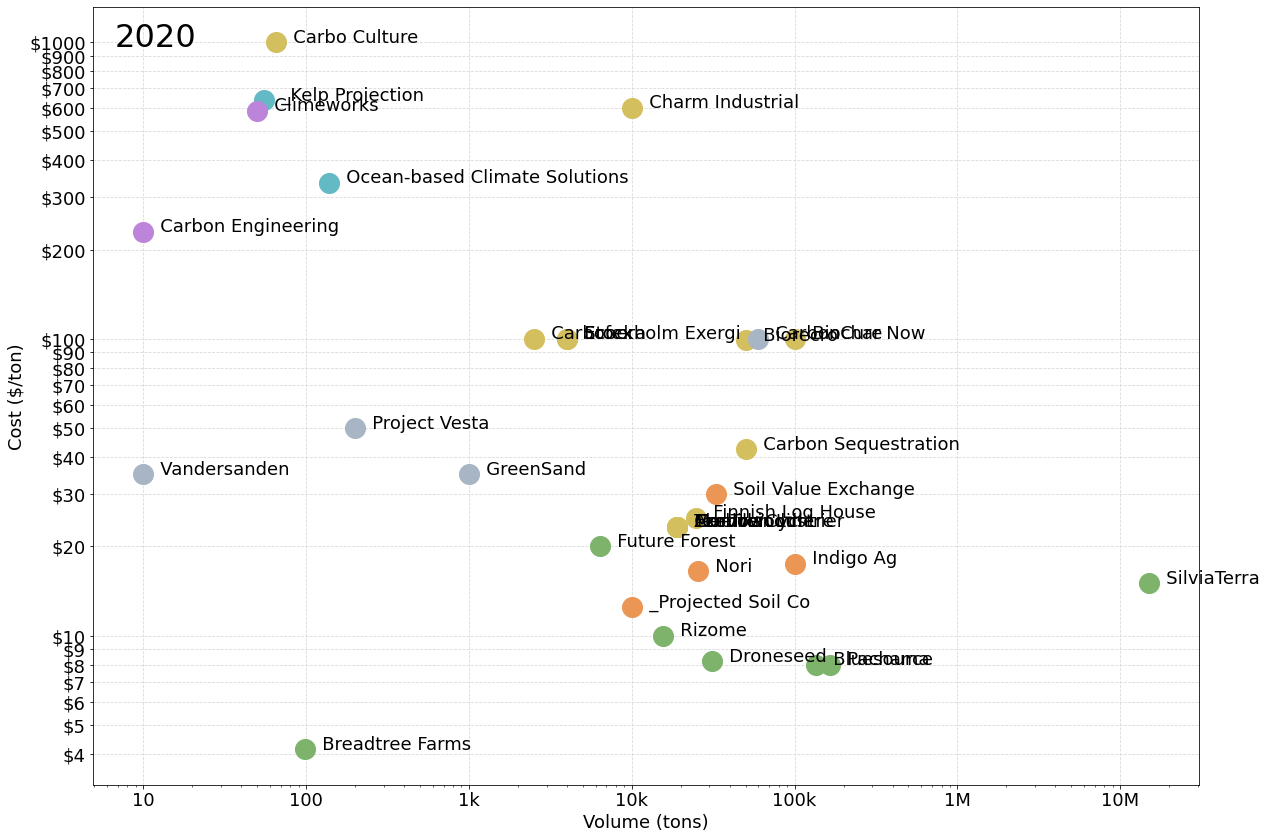

In [89]:
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
plot_vcp(df[sel], end=2020, save_as='vcp_2020')

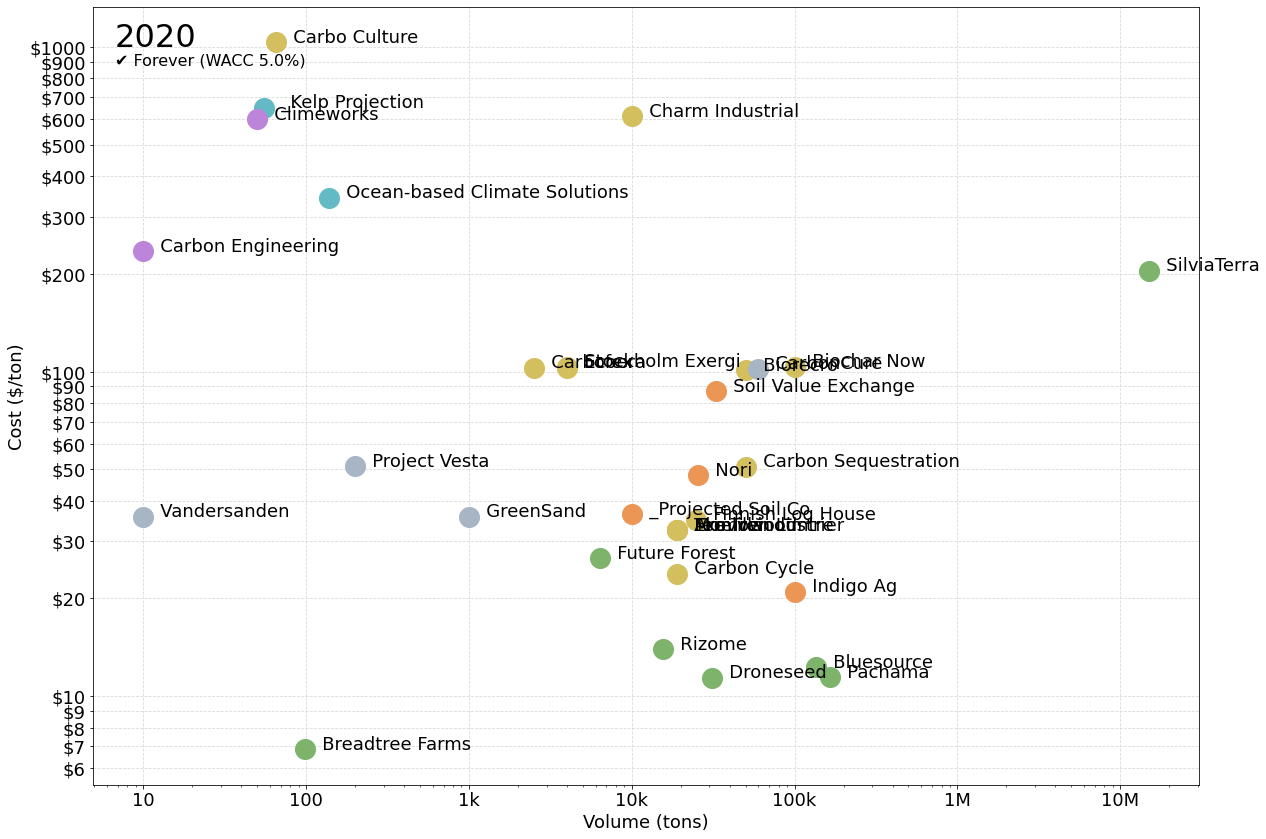

In [90]:
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
plot_vcp(df[sel], end=2020, leak_cost_wacc=1.05, save_as='vcp_2020_leak1.05')

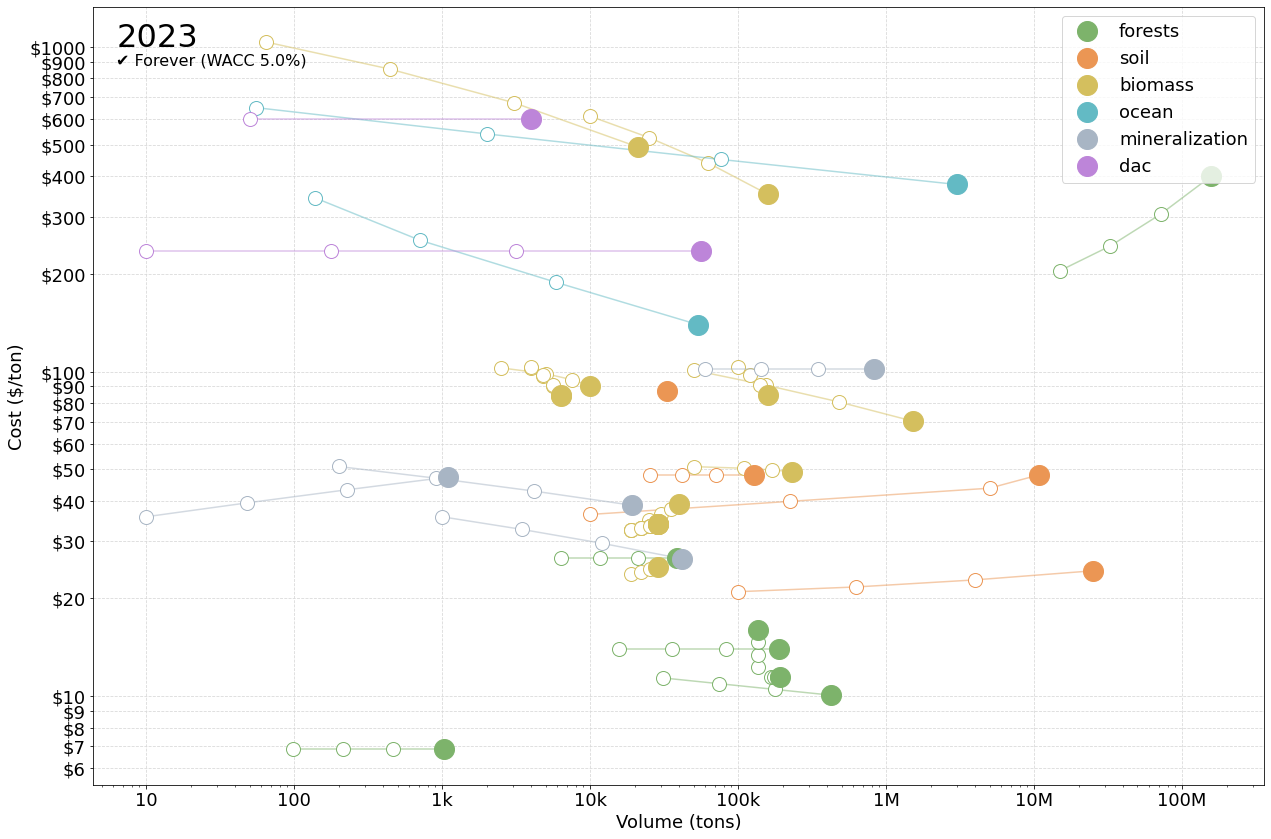

In [105]:
#TMPPPPPPPPPP
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
plot_vcp(df[sel], end=2023, leak_cost_wacc=1.05, do_text=False, do_legend=True, save_as='vcp_2020_leak1.05')

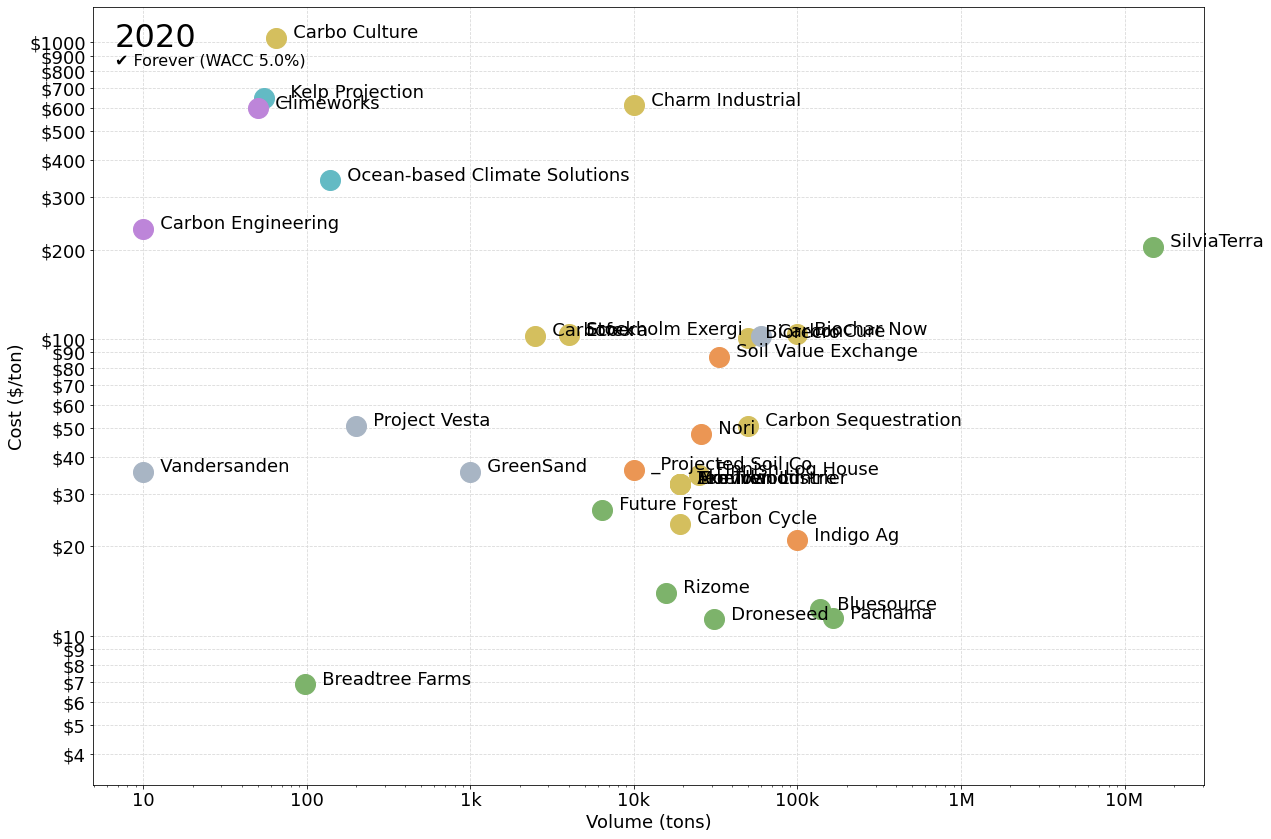

In [81]:
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
ax = plot_vcp(df[sel], end=2020, ret_ax=True); clf()   # Get axis of above plot
plot_vcp(df[sel], end=2020, leak_cost_wacc=1.05, ax=ax, save_as='vcp_2020_leak1.05_sameax')

In [82]:
# TODO: custom plot showing how costs shift up. Draw both non-leaky and leaky points.

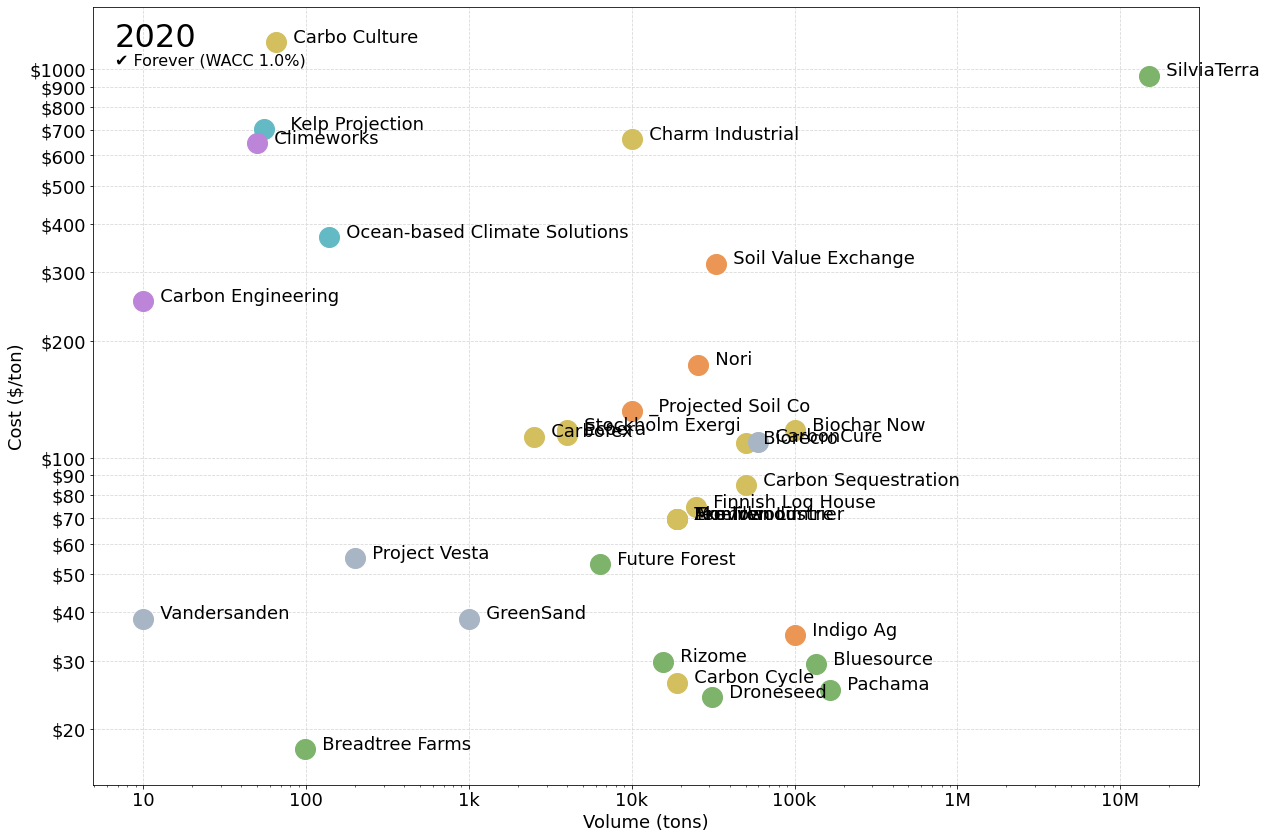

In [83]:
# Example just to show Forever Ton cost with very high cost of future capital
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
plot_vcp(df[sel], end=2020, leak_cost_wacc=1.01, save_as='vcp_2020_leak1.01')

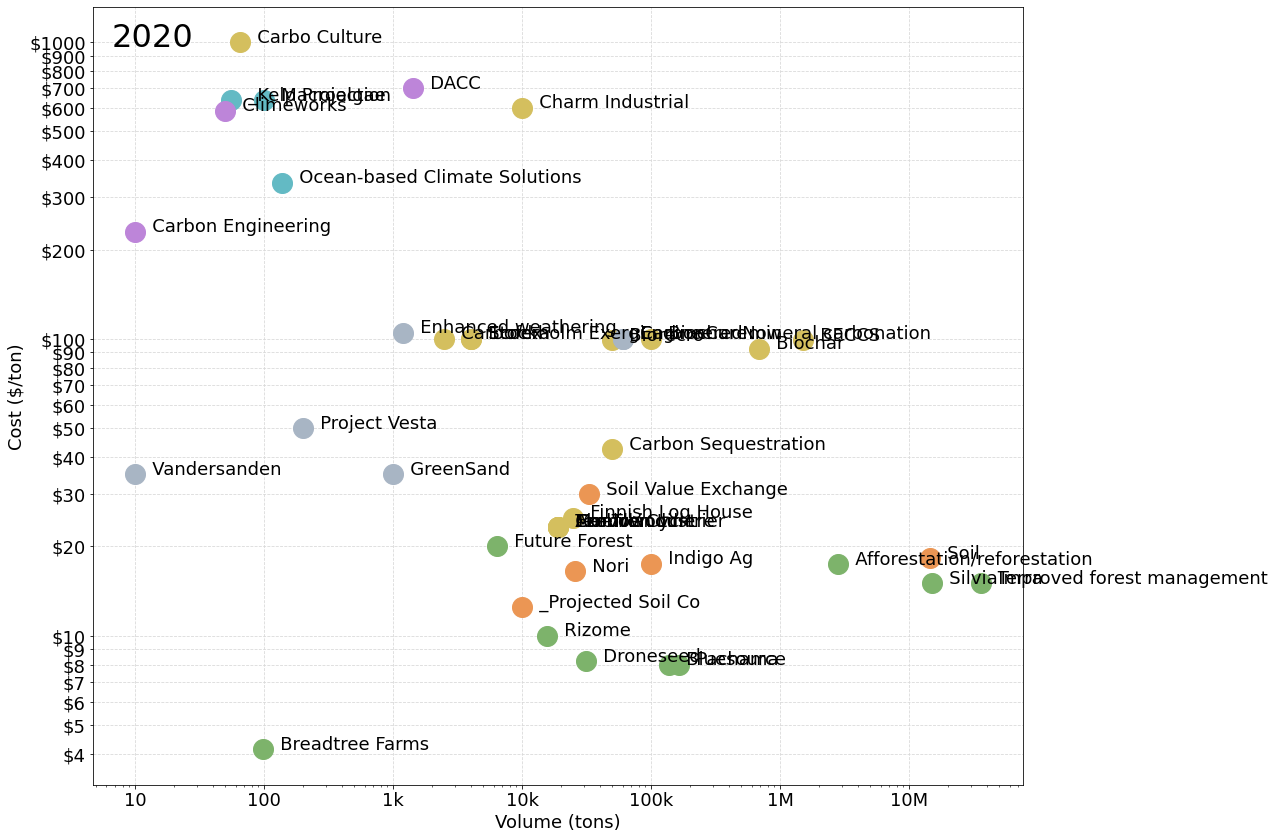

In [84]:
# Aggregate: messy version with companies and aggregations
figsize(18,12)
sel = (df.valid_vc & (sel_prefer_aggregate | (df.projection_group == 'company')))
plot_vcp(df[sel], end=2020, save_as='vcp_2020_coandag')

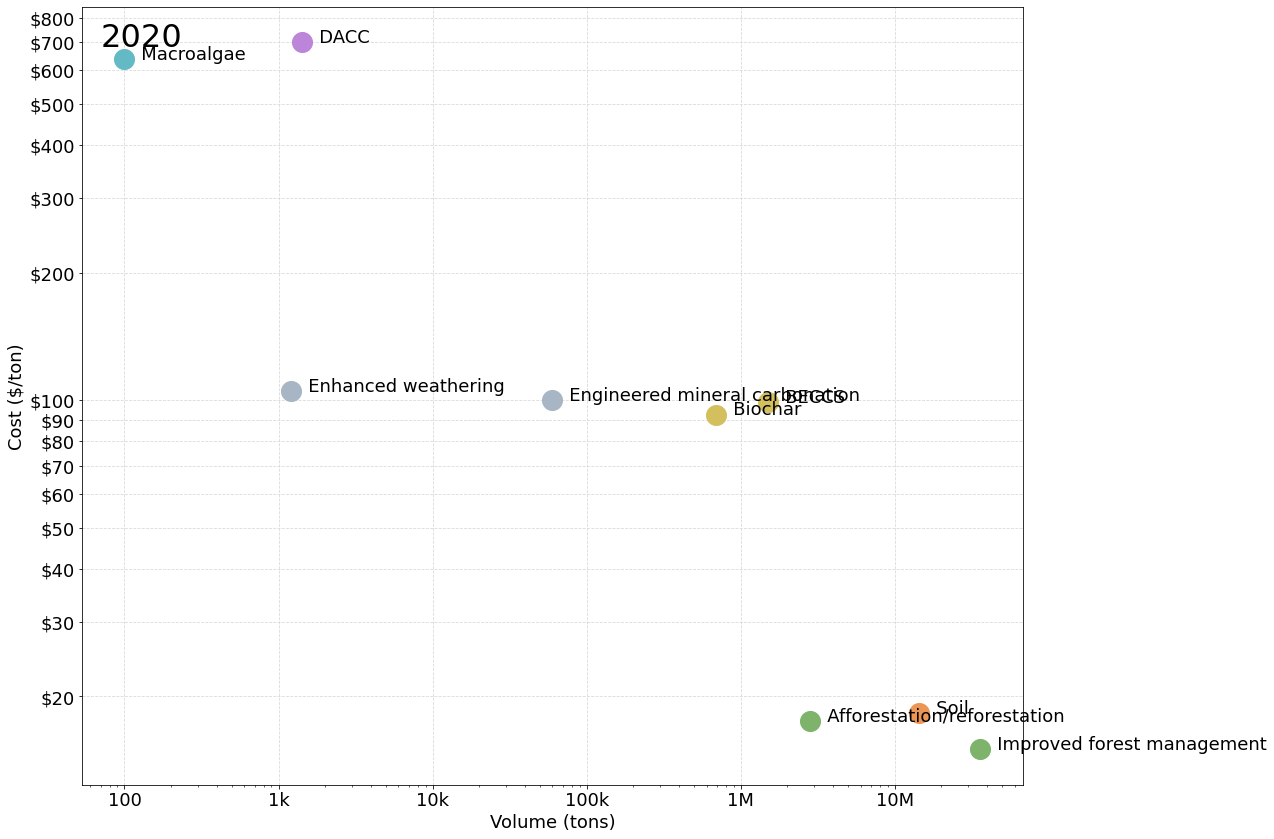

In [85]:
# Aggregate: Just aggregations
figsize(18,12)
sel = (df.valid_vc & sel_prefer_aggregate)
plot_vcp(df[sel], end=2020, save_as='vcp_2020_ag')

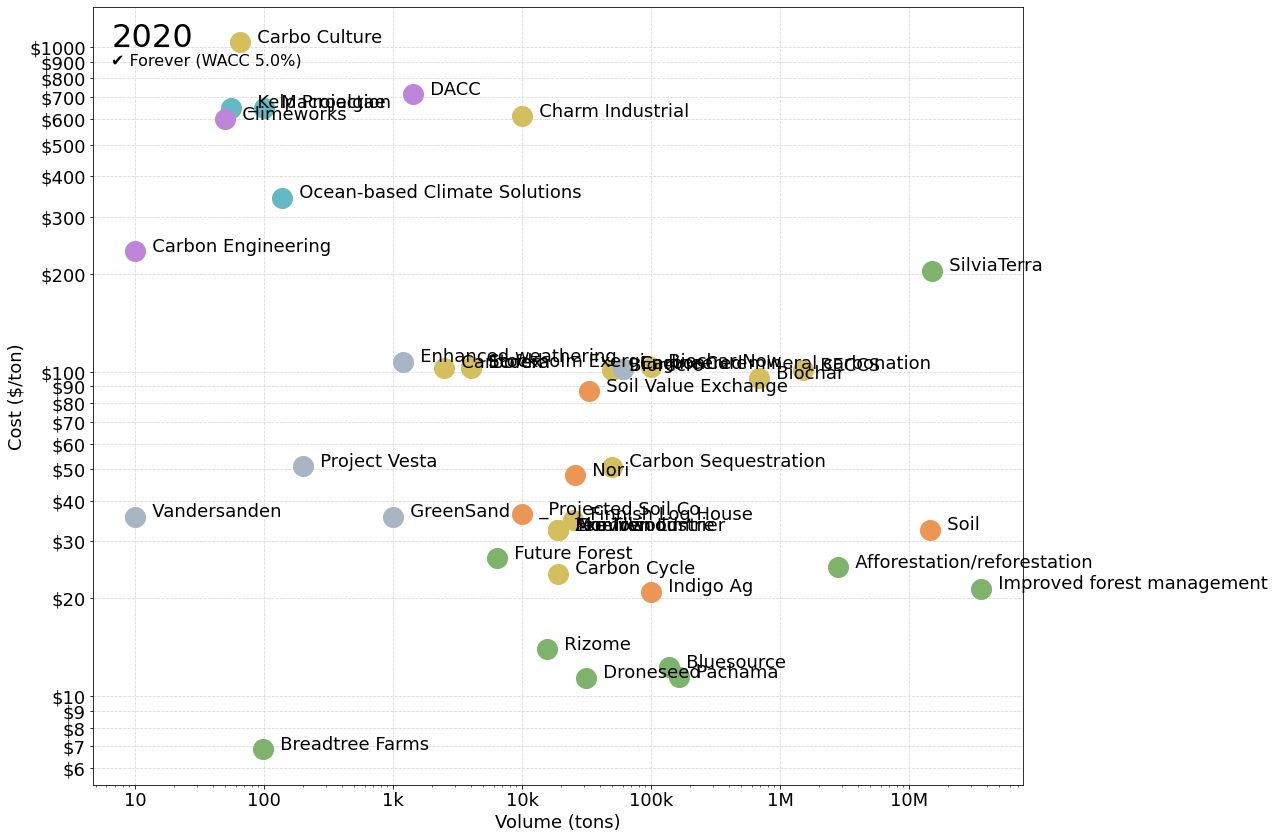

In [86]:
# Aggregate: messy version with companies and aggregations. With leak.
# Will generate errors if you ignored the "# Ensure permanence_value is filled in where needed" block above
figsize(18,12)
sel = (df.valid_vc & (sel_prefer_aggregate | (df.projection_group == 'company')))
plot_vcp(df[sel], end=2020, leak_cost_wacc=1.05, save_as='vcp_2020_coandag_leak1.05')

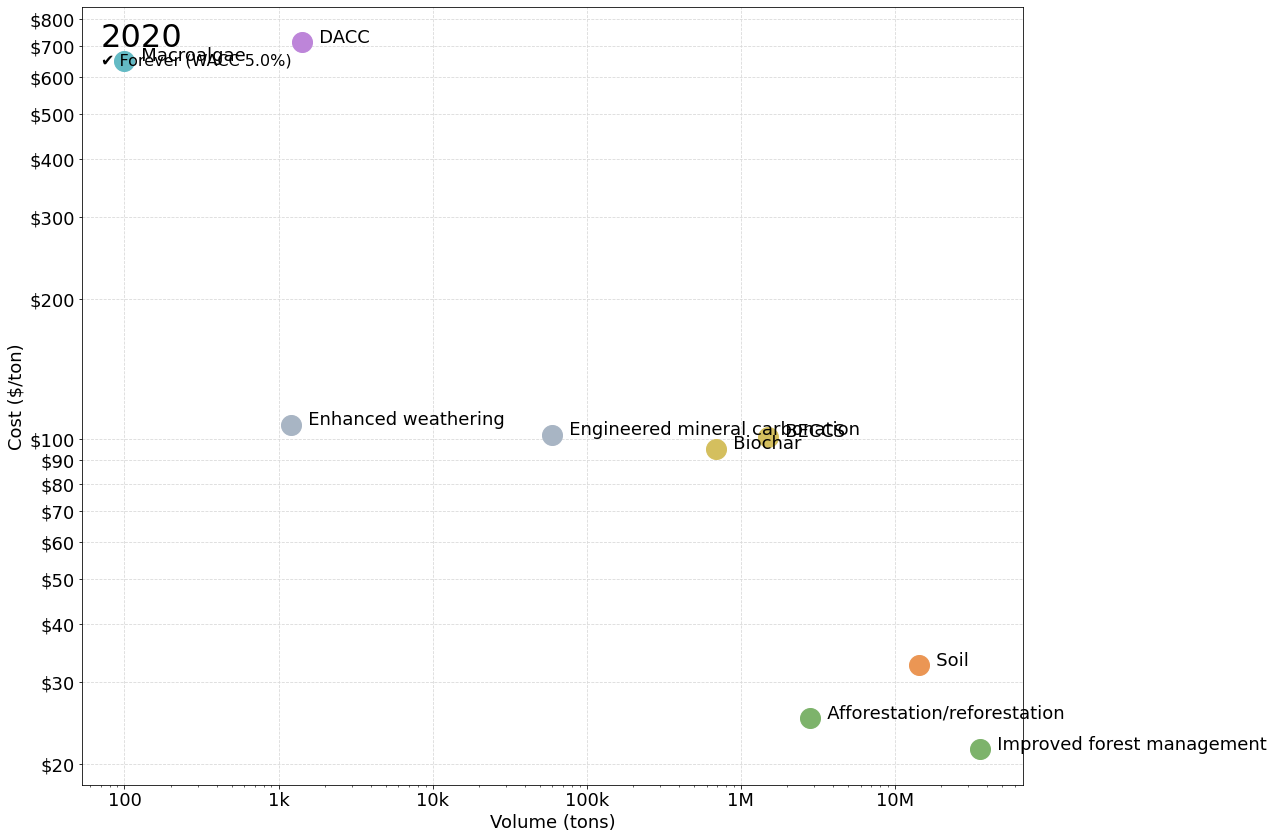

In [87]:
# Aggregate: Just aggregations. With leak.
figsize(18,12)
sel = (df.valid_vc & sel_prefer_aggregate)
plot_vcp(df[sel], end=2020, leak_cost_wacc=1.05, save_as='vcp_2020_ag_leak1.05')

### At the year 2035

In [ ]:
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
plot_vcp(df[sel], end=2035, save_as='vcp_2035')

In [ ]:
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
plot_vcp(df[sel], end=2035, leak_cost_wacc=1.05, save_as='vcp_2035_leak1.05')

In [ ]:
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
ax = plot_vcp(df[sel], end=2035, ret_ax=True); clf()   # Get axis of above plot
plot_vcp(df[sel], end=2035, leak_cost_wacc=1.05, ax=ax, save_as='vcp_2035_leak1.05_sameax')

In [ ]:
# TODO: custom plot showing how costs shift up. Draw both non-leaky and leaky points.

In [ ]:
# Aggregate: messy version with companies and aggregations
figsize(18,12)
sel = (df.valid_vc & (sel_prefer_aggregate | (df.projection_group == 'company')))
plot_vcp(df[sel], end=2035, save_as='vcp_2035_coandag')

In [ ]:
# Aggregate: Just aggregations
figsize(18,12)
sel = (df.valid_vc & sel_prefer_aggregate)
plot_vcp(df[sel], end=2035, save_as='vcp_2035_ag')

In [ ]:
# Aggregate: messy version with companies and aggregations. With leak.
# Will generate errors if you ignored the "# Ensure permanence_value is filled in where needed" block above
figsize(18,12)
sel = (df.valid_vc & (sel_prefer_aggregate | (df.projection_group == 'company')))
plot_vcp(df[sel], end=2035, leak_cost_wacc=1.05, save_as='vcp_2035_coandag_leak1.05')

In [ ]:
# Aggregate: Just aggregations. With leak.
figsize(18,12)
sel = (df.valid_vc & sel_prefer_aggregate)
plot_vcp(df[sel], end=2035, leak_cost_wacc=1.05, save_as='vcp_2035_ag_leak1.05')

### Animated versions (takes a while to plot and save all)

Animated versions have matches axes (though some shift when text goes off the right side).

In [ ]:
# Expensive: generate each frame for animation
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
ax = plot_vcp(df[sel], end=year, ret_ax=True)   # Get axis of final plot
for year in range(first_year, last_year + 1):
    clf()
    plot_vcp(df[sel], end=year, ax=ax, save_as='vcp_anim_%d' % year)

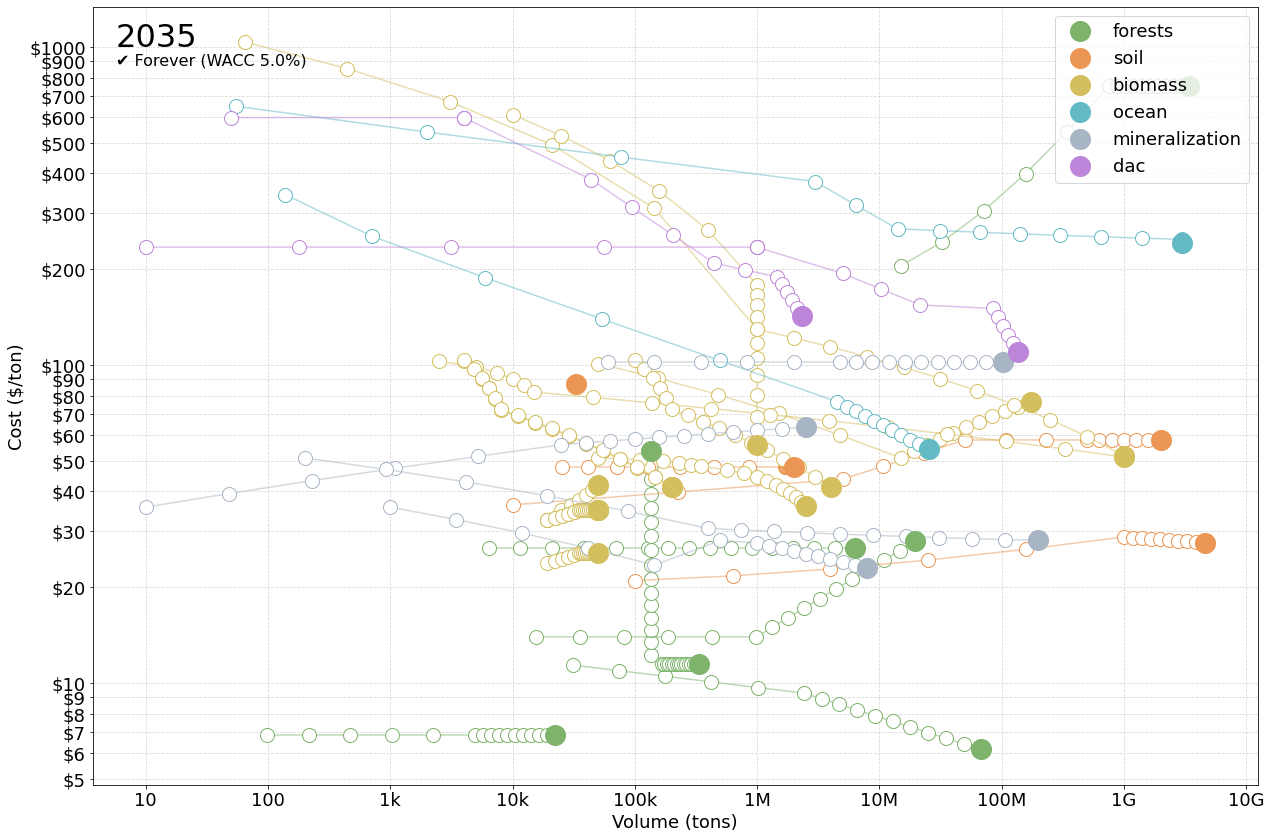

In [106]:
# Expensive: generate each frame for animation. Version used for animation in final presentation
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
ax = plot_vcp(df[sel], end=year, leak_cost_wacc=1.05, do_text=False, do_legend=True, ret_ax=True)   # Get axis of final plot
for year in range(first_year, last_year + 1):
    clf()
    plot_vcp(df[sel], end=year, ax=ax, leak_cost_wacc=1.05, do_text=False, do_legend=True, save_as='vcp_anim_%d' % year)

In [ ]:
### TODO: more animated versions if desired.

### Misc older plots

In [ ]:
if False:
    # Linear versions for Jenny
    figsize(18,12)
    sel = (df.valid_vc & (df.projection_group == 'company'))
    #plot_vcp(df[sel], save_as='carbon_plan_vol_cost_pt')
    plot_vcp(df[sel], end=2035, logx=False, logy=False, save_as='vcp_2035_linx_liny')

## Volume vs. Cost as Curve (`vcc_*` files)

In [ ]:
from matplotlib.ticker import EngFormatter

def plot_vcc(df_in, year=2020, logx=False, logy=True, ax=None, save_as=None):
    '''Plot data from first year to last year, highlighting last year.'''
    
    # Create a copy so we can add temp columns and sort
    df = df_in.copy()
    
    # Use average volume and cost for now
    df['vv'] = df.loc[:, ['vol_%d_min' % year, 'vol_%d_max' % year]].mean(axis=1)
    df['cc'] = df.loc[:, ['cost_%d_min' % year, 'cost_%d_max' % year]].mean(axis=1)
    
    # Sort from cheapest to most expensive
    df.sort_values(by='cc', inplace=True)
    
    df['vv_cumsum'] = df.vv.cumsum()
    
    # Deal with logx and logy
    min_y = 0 if not logy else 0.1

    last_vv_cumsum = 10.0
    for ii, proj in enumerate(df.itertuples()):
        #print('project is', type(project))
        #project = df.iloc[ii]
        clr = proj.clr
        vols = get_vols(project)
        costs = get_costs(project)
        
        # Just line
        #plot([last_vv_cumsum, proj.vv_cumsum], [proj.cc, proj.cc], '-', c=proj.clr, lw=2)
        
        # Left point
        plot([last_vv_cumsum], [proj.cc], 'o', c=proj.clr, ms=16)
        text(last_vv_cumsum, proj.cc, '  %s  ' % proj.applicant)

        # Right point
        #plot([proj.vv_cumsum], [proj.cc], 'o', c=proj.clr, ms=16)
        #text(proj.vv_cumsum, proj.cc, '%s  ' % proj.applicant, ha='right')

        # Fill below
        fill_between([last_vv_cumsum, proj.vv_cumsum], [proj.cc, proj.cc], color=proj.clr)
        
        last_vv_cumsum = proj.vv_cumsum
    annotate('%s' % year, xy=(.02, .93), xycoords='axes fraction', fontsize=32, va='top')
    xlabel('Cumulative Volume (tons)')
    ylabel('Cost ($/ton)')
    if logx: gca().set_xscale('log')
    if logy: gca().set_yscale('log')
    nice_vc_axes(skip_x=True)
    gca().xaxis.set_major_formatter(EngFormatter())
    if ax: axis(ax)
    #tight_layout()
    if save_as:
        savefigs(save_as)

### In the years 2020, 2025, 2030, 2035

In [ ]:
# Just one unsaved plot
figsize(18,10)
sel = (df.valid_vc & (df.projection_group == 'company'))
plot_vcc(df[sel], 2020)

In [ ]:
# Plot all sectors
figsize(18,10)
sel = (df.valid_vc & (df.projection_group == 'company'))
for year in [2020, 2025, 2030, 2035]:
    figure()
    plot_vcc(df[sel], year, logx=False, logy=True, save_as='vcc_%d' % year)

In [ ]:
# Plot all sectors, aggregations
figsize(18,10)
sel = (df.valid_vc & sel_prefer_aggregate)
for year in [2020, 2025, 2030, 2035]:
    figure()
    plot_vcc(df[sel], year, logx=False, logy=True, save_as='vcc_%d_ag' % year)

### Animated versions (takes a while to plot and save all)

In [ ]:
# Generate each frame for animation
figsize(18,10)
sel = (df.valid_vc & (df.projection_group == 'company'))
# Plot and compute final axes
plot_vcc(df[sel], 2035, logx=False, logy=True)
ax = axis()
for year in range(first_year, last_year + 1):
    clf()
    plot_vcc(df[sel], year, logx=False, logy=True, ax=ax, save_as='vcc_%d_anim_sameax' % year)

In [ ]:
# Generate each frame for animation
figsize(18,10)
sel = (df.valid_vc & (df.projection_group == 'company'))
# Plot and compute final axes
for year in range(first_year, last_year + 1):
    clf()
    plot_vcc(df[sel], year, logx=False, logy=True, save_as='vcc_%d_anim' % year)

### Custom versions

In [ ]:
# Plot a single sector supply curve for 2020
figsize(18,4)
sel = (df.valid_vc & (df.projection_group == 'company') & (df.pt == 'soil'))
plot_vcc(df[sel], 2020, logx=False, logy=True, save_as='vcc_2020_soil')

In [ ]:
# Plot a single sector supply curve for the next three years
figsize(18,4)
sel = (df.valid_vc & (df.projection_group == 'company') & (df.pt == 'soil'))
plot_vcc(df[sel], 2022, logx=False, logy=True)
ax=axis(); clf()
print(ax)
plot_vcc(df[sel], 2020, logx=False, logy=True, ax=ax, save_as='vcc_2020_soil_sameax')
figure()
plot_vcc(df[sel], 2021, logx=False, logy=True, ax=ax, save_as='vcc_2021_soil_sameax')
figure()
plot_vcc(df[sel], 2022, logx=False, logy=True, ax=ax, save_as='vcc_2022_soil_sameax')

# Misc static plots for presentation

In [ ]:
tt = arange(30)

In [ ]:
plot(tt, exp(-(1/15) * tt), lw=3)
axhline(0, color='k')
axvline(0, color='k')
axvline(15, ls=':', color='k')
savefigs('example_decay_exponential')

In [ ]:
plot(tt, maximum(1 - (1/15 * tt), 0), lw=3)
axhline(0, color='k')
axvline(0, color='k')
axvline(15, ls=':', color='k')
savefigs('example_decay_linear')

In [ ]:
plot(tt, (tt < 15) * 1.0, lw=3)
axhline(0, color='k')
axvline(0, color='k')
axvline(15, ls=':', color='k')
savefigs('example_decay_step')

# Scratch

In [ ]:
# display_full(df.iloc[91:92])

In [ ]:
# OLD
if False:
    # Fill in missing data with copies of old data until new data is encountered.
    for year in range(2021, 2036):
        prev_min = 'cost_%s_min' % (year - 1)
        this_min = 'cost_%s_min' % year
        sel = df.valid_vc & (df[this_min] == '')
        df.loc[sel, this_min] = df[sel][prev_min]

        prev_max = 'cost_%s_max' % (year - 1)
        this_max = 'cost_%s_max' % year
        sel = df.valid_vc & (df[this_max] == '')
        df.loc[sel, this_max] = df[sel][[this_min, prev_max]].max(axis=1)

        prev_min = 'vol_%s_min' % (year - 1)
        this_min = 'vol_%s_min' % year
        sel = df.valid_vc & (df[this_min] == '')
        df.loc[sel, this_min] = df[sel][prev_min]

        prev_max = 'vol_%s_max' % (year - 1)
        this_max = 'vol_%s_max' % year
        sel = df.valid_vc & (df[this_max] == '')
        df.loc[sel, this_max] = df[sel][[this_min, prev_max]].max(axis=1)

In [ ]:
#OLD
if False:
    def plot_single_vol_cost_curve(df, save_as=None, plot_legend=True):
        df = df.sort_values(by='cost_value')

        cv_cost = []
        cv_vol = []
        for ii, project in enumerate(df.itertuples()):
            # Left point
            cv_vol.append(0 if len(cv_vol) == 0 else cv_vol[-1])
            cv_cost.append(project.cost_value)
            # Right point
            cv_vol.append(cv_vol[-1] + project.volume_value)
            cv_cost.append(project.cost_value)    
            clr = project.clr
            pt = project.pt
        cv_cost = array(cv_cost)
        cv_vol = array(cv_vol)
        plot(cv_vol, cv_cost, 'o', mfc='w', mec=clr, ms=12)
        fill_between(cv_vol, cv_cost, color=clr)
        xlabel('Volume (tons)')
        ylabel('Cost ($/ton)')
        if plot_legend:
            legend((pt,), loc='upper left')
        tight_layout()
        ylim(bottom=0)
        if save_as:
            savefigs(save_as)